**Mask-RCNN Sample Starter Model for the RSNA Pneumonia Detection Challenge**

[MD.ai](https://www.md.ai). The dataset for this challenge, created on the MD.ai platform in collaboration with the Radiological Society of North America (RSNA), the Society of Thoracic Radiology (STR), the US National Institutes of Health (NIH), and Kaggle.
This notebook covers the basics of parsing the competition dataset, training using a detector basd on the [Mask-RCNN algorithm](https://arxiv.org/abs/1703.06870) for object detection and instance segmentation.    
**Note that the Mask-RCNN detector configuration parameters have been selected to reduce training time for demonstration purposes, they are not optimal.
**

This is based on our deep learning for medical imaging lessons: 

- Lesson 1. Classification of chest vs. adominal X-rays using TensorFlow/Keras [Github](https://github.com/mdai/ml-lessons/blob/master/lesson1-xray-images-classification.ipynb) [Annotator](https://public.md.ai/annotator/project/PVq9raBJ)
- Lesson 2. Lung X-Rays Semantic Segmentation using UNets. [Github](https://github.com/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb)
[Annotator](https://public.md.ai/annotator/project/aGq4k6NW/workspace) 
- Lesson 3. RSNA Pneumonia detection using Kaggle data format [Github](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-kaggle.ipynb) [Annotator](https://public.md.ai/annotator/project/LxR6zdR2/workspace) 
- Lesson 3. RSNA Pneumonia detection using MD.ai python client library [Github](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb) [Annotator](https://public.md.ai/annotator/project/LxR6zdR2/workspace) 

*Copyright 2018 MD.ai, Inc.   
Licensed under the Apache License, Version 2.0*

In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

### First: Install Kaggle API for download competition data.

In [2]:
DATA_DIR = '../input'

# Directory to save logs and trained model
ROOT_DIR = '../working'

###  MD.ai Annotator 

Additionally, If you are interested in augmenting the existing annotations, you can use the MD.ai annotator to view DICOM images, and create annotatios to be exported.  
MD.ai annotator project URL for the Kaggle dataset: https://public.md.ai/annotator/project/LxR6zdR2/workspace

**Annotator features**
- The annotator can be used to view DICOM images and create image and exam level annotations.
- You can apply the annotator to filter by label, adjudicate annotations, and assign annotation tasks to your team.
- Notebooks can be built directly within the annotator for rapid model development.
- The data wrangling is abstracted away by the interface and by our MD.ai library.
- Simplifies image annotation in order to widen the participation in the futrue of medical image deep learning.

The annotator allows you to create initial annotations, build and run models, modify/finetune the annotations based on predicted values, and repeat.  
The MD.ai python client library implements functions to easily download images and annotations and to prepare the datasets used to train the model for classification. See the following example notebook for parsing annotations and training using MD.ai annotator: 
https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb  
- MD.ai URL: https://www.md.ai  
- MD.ai documentation URL: https://docs.md.ai/

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [3]:
#!git clone https://www.github.com/matterport/Mask_RCNN.git
#os.chdir('Mask_RCNN')
#!python setup.py -q install

In [4]:
# Import Mask RCNN
sys.path.append(os.path.join("/home/mehul/kaggle/pneumonia-detection-2018", 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [5]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_1_test_images')

### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [6]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [7]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    RPN_ANCHOR_SCALES = (16, 32, 64, 128,256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.4
    DETECTION_NMS_THRESHOLD = 0.1
    TRAIN_BN = 1
    STEPS_PER_EPOCH = 320
    # Image mean (RGB)
    MEAN_PIXEL = np.array([0.0,0.0,0.0])    
    # Weight decay regularization
    WEIGHT_DECAY = 0.0001
    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64 #300
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000
    RPN_NMS_THRESHOLD = 0.9
    MAX_GT_INSTANCES = 10
    DETECTION_MAX_INSTANCES = 5 
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        5
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES   

In [8]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        image = (image - np.mean(image))/np.std(image)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [9]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_1_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [10]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [11]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [12]:
# show dicom fields 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.4011.1517874305.405903
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: 'b35dfbda-395c-4c9d-befb-331f6ac3da84'
(0010, 0020) Patient ID                          LO: 'b35dfbda-395c-4c9d-befb-331f6ac3da84'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

In [13]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets
**Note: We have only used only a portion of the images for demonstration purposes. See comments below.**
 
 - To use all the images do: image_fps_list = list(image_fps)
 - Or change the number of images from 100 to a custom number

In [14]:
######################################################################
# Modify this line to use more or fewer images for training/validation. 
# To use all images, do: image_fps_list = list(image_fps)
image_fps_list = list(image_fps) 
#####################################################################

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

23115 2569


### Create and prepare the training dataset using the DetectorDataset class.

In [15]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

### Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

In [16]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    6067a125-b3e5-4723-bc09-0d502ade3894
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 8565, dtype: object]

In [17]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

(1024, 1024, 3)
../input/stage_1_train_images/3ae1c3de-e2a7-44f5-b794-b1ef71640d0f.dcm
[1]


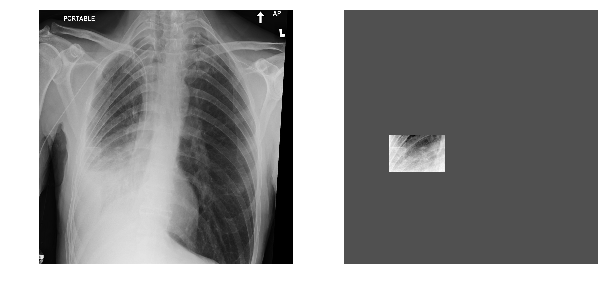

In [18]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [19]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

### Image Augmentation. Try finetuning some variables to custom values

In [20]:
# Image augmentation 
augmentation = iaa.SomeOf((0, 2), [
    iaa.Affine(
        scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
        rotate=(-5, 5),
        shear=(-2, 2)
    ),
    iaa.Multiply((0.9, 1.1))
])

### Now it's time to train the model. Note that training even a basic model can take a few hours. 

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [21]:
NUM_EPOCHS = 50

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all',
            augmentation=augmentation)

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 0. LR=0.001

Checkpoint Path: ../working/pneumonia20180915T2037/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a 

320/320 [==============================] - 127s 396ms/step - loss: 1.8145 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.5194 - mrcnn_class_loss: 0.2795 - mrcnn_bbox_loss: 0.4899 - mrcnn_mask_loss: 0.4957 - val_loss: 1.7056 - val_rpn_class_loss: 0.0286 - val_rpn_bbox_loss: 0.4726 - val_mrcnn_class_loss: 0.2525 - val_mrcnn_bbox_loss: 0.4844 - val_mrcnn_mask_loss: 0.4676
Epoch 31/50
320/320 [==============================] - 126s 395ms/step - loss: 1.8001 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.5156 - mrcnn_class_loss: 0.2735 - mrcnn_bbox_loss: 0.5008 - mrcnn_mask_loss: 0.4809 - val_loss: 1.7059 - val_rpn_class_loss: 0.0283 - val_rpn_bbox_loss: 0.4761 - val_mrcnn_class_loss: 0.2853 - val_mrcnn_bbox_loss: 0.4518 - val_mrcnn_mask_loss: 0.4643
Epoch 32/50
320/320 [==============================] - 135s 423ms/step - loss: 1.7637 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.4941 - mrcnn_class_loss: 0.2705 - mrcnn_bbox_loss: 0.4897 - mrcnn_mask_loss: 0.4841 - val_loss: 1.7562 - val_rpn_class_l

In [22]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

No weight files in ../working/pneumonia20180915T1627
No weight files in ../working/pneumonia20180915T1632
No weight files in ../working/pneumonia20180915T1643
No weight files in ../working/pneumonia20180915T1650
No weight files in ../working/pneumonia20180915T1654
No weight files in ../working/pneumonia20180915T1731
No weight files in ../working/pneumonia20180915T1749
No weight files in ../working/pneumonia20180915T2009
No weight files in ../working/pneumonia20180915T2012
No weight files in ../working/pneumonia20180915T2022
No weight files in ../working/pneumonia20180915T2036
Found model ../working/pneumonia20180915T2037/mask_rcnn_pneumonia_0050.h5


In [23]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../working/pneumonia20180915T2037/mask_rcnn_pneumonia_0050.h5
Re-starting from epoch 50


In [24]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

Note that we trained only one epoch for **demonstration purposes ONLY**. You might be able to improve performance running more epochs. 

(512, 512, 3)

*** No instances to display *** 

(512, 512, 3)

*** No instances to display *** 

(512, 512, 3)
(512, 512, 3)


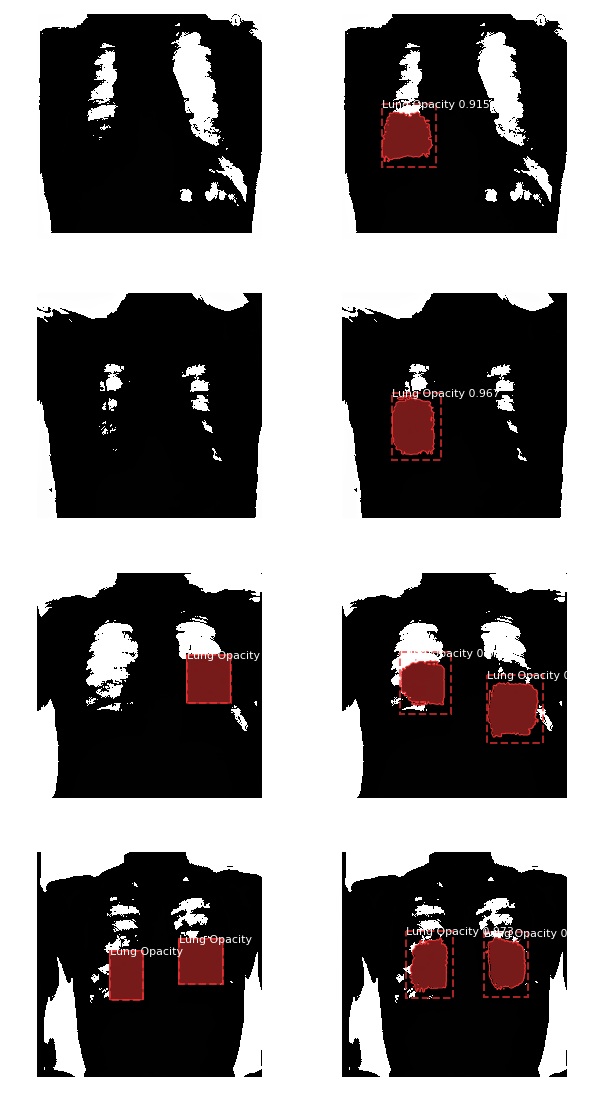

In [25]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [26]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

### Final steps - Create the submission file

In [27]:
# Make predictions on test images, write out sample submission 
def predict(image_fps, filepath='submission.csv', min_conf=0.95): 
    
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE 
    with open(filepath, 'w') as file:
      file.write("patientId,PredictionString\n")
      for image_id in tqdm(image_fps): 
        ds = pydicom.read_file(image_id)
        image = ds.pixel_array
        image = (image - np.mean(image))/np.std(image)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
        image, window, scale, padding, crop = utils.resize_image(
            image,
            min_dim=config.IMAGE_MIN_DIM,
            min_scale=config.IMAGE_MIN_SCALE,
            max_dim=config.IMAGE_MAX_DIM,
            mode=config.IMAGE_RESIZE_MODE)
            
        patient_id = os.path.splitext(os.path.basename(image_id))[0]

        results = model.detect([image])
        r = results[0]

        out_str = ""
        out_str += patient_id 
        out_str += ","
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        if len(r['rois']) == 0: 
            pass
        else: 
            num_instances = len(r['rois'])
  
            for i in range(num_instances): 
                if r['scores'][i] > min_conf: 
                    out_str += ' '
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                       width*resize_factor, height*resize_factor)   
#                     bboxes_str = "{} {} {} {}".format(x1, y1, \
#                                                       width, height)
                    out_str += bboxes_str

        file.write(out_str+"\n")

In [28]:
# predict only the first 50 entries
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
print(submission_fp)
predict(test_image_fps, filepath=submission_fp)

  0%|          | 1/1000 [00:00<01:57,  8.50it/s]

../working/submission.csv


100%|██████████| 1000/1000 [01:52<00:00,  8.92it/s]


In [29]:
output = pd.read_csv(submission_fp, names=['patientId', 'PredictionString'])
output.head(100)

,patientId,PredictionString
0,patientId,PredictionString
1,232f6bcd-2006-459a-9b30-b51beea28044,0.98 556.0 354.0 322.0 422.0 0.96 126.0 488.0...
2,c0760d93-760c-4be7-afca-5e9914e6f8f1,0.96 654.0 382.0 276.0 428.0
3,246bf123-5a0d-4a3d-b4b4-6e442f8a830c,0.96 568.0 524.0 298.0 308.0
4,1505f53a-4da5-416e-a279-66849672051c,0.96 208.0 578.0 192.0 234.0
5,23817810-a792-4c97-a15c-24d3c9da1f3b,0.96 636.0 474.0 252.0 322.0 0.96 170.0 612.0...
6,1d5af9ab-1f62-47b2-980f-71e8409d7c3c,0.98 592.0 360.0 252.0 278.0 0.97 226.0 424.0...
7,12eddc6c-2d66-4df7-8da1-edd5b5fc81a9,0.96 590.0 406.0 280.0 380.0
8,0e533087-5959-46e5-9fa5-95761a7d472f,0.97 214.0 276.0 248.0 306.0
9,20903dac-37a5-4afb-b88d-18ac705c5c08,0.97 244.0 414.0 216.0 332.0


In [30]:
## show submission.csv content
#os.chdir(ROOT_DIR)
#!cat submission.csv

In [31]:
# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)



In [32]:
# remove files to allow committing (hit files limit otherwise)
#!rm -rf /kaggle/working/Mask_RCNN

2f6ac842-e243-4c5f-a48c-d70862e316d5
[188 124 356 235]
x 248 y 376 h 222 w 336
22956af6-6152-4458-a39d-a45706b8a96c
[246 127 386 241]
x 254 y 492 h 228 w 280
[261 340 432 468]
x 680 y 522 h 256 w 342
2a5752c7-6f90-4c5f-a5bd-9dd7736097ef
[205  83 342 186]
x 166 y 410 h 206 w 274
2c376b9a-167a-43d3-bcc2-b4af32fb9f74
[271 111 416 241]
x 222 y 542 h 260 w 290
[ 67 102 163 218]
x 204 y 134 h 232 w 192
0479d585-4e1e-44b3-aabe-4aa8437a54c5
[ 75 138 165 249]
x 276 y 150 h 222 w 180
[161 105 309 224]
x 210 y 322 h 238 w 296
27feebaa-f4dc-4c68-9348-f0ff35134e43
[288 134 393 253]
x 268 y 576 h 238 w 210
[261 324 420 442]
x 648 y 522 h 236 w 318


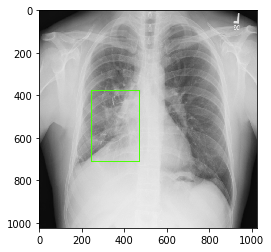

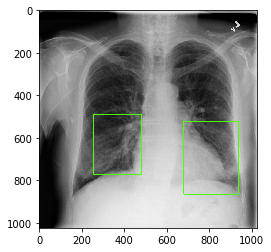

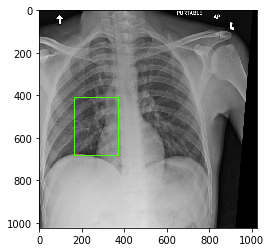

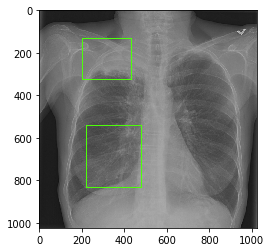

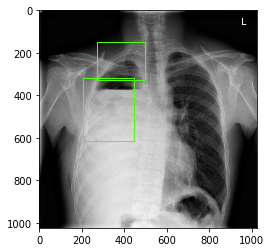

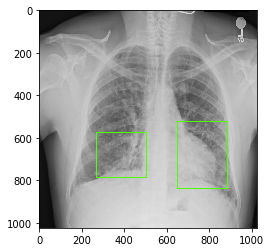

In [34]:
visualize()
visualize()
visualize()
visualize()
visualize()
visualize()